# LangGraph

LangGraph is a framework that allows you to define execution flows. It is designed for building agentic systems.

Check the [LangGraph reference](https://reference.langchain.com/python/langgraph/) for official detailed explanation of the main features of the LangGraph.

In [4]:
from typing import TypedDict, Literal, Annotated

import langgraph
from langgraph.types import Command
from langgraph.graph import END, START, StateGraph

## State

The **state** is the object that moves through the entire graph. It provides the input information to the nodes and passes the information from the current node to the next one.

The schema of the `State` must be provided when defining of the `langgraph.graph.StateGraph`. Supported ways to define a schema include: `typing.TypedDict`, `dataclasses.dataclass`, or `pydantic.BaseModel`.

Check more cases in the [State](langgraph/state.ipynb)

---

Consider a case in which the state is defined as a `dataclass`. The following cell creates a graph that processes a `State` dataclass instance and increments the `inp` attribute. 

In [13]:
from dataclasses import dataclass


@dataclass
class State:
    inp: int


def my_node(state: State):
    print(state)
    state.inp += 1
    return state


builder = StateGraph(State)
builder.add_node("my", my_node)

builder.add_edge(START, "my")
builder.add_edge("my", END)

graph = builder.compile()

The following cell invokes the graph for `State(inp=4)`.

In [15]:
graph.invoke(State(inp=4))

State(inp=4)


{'inp': 5}

## Reducing

If two graph flows join at the same node and both return a value, there will be a conflict. You must specify a strategy for merging the outputs using a **reducer function**.

THe **reducer function** can be defined as metatdata of the `typing.Annotated` for the specific attribute. This function will be applied if the outputs from those nodes need to be processed in some way. The most common way is to use the `operator.add` function, which is equivalent to simply apply the `+` operator.

Check more in [Reducing](langgraph/reducing.ipynb) page.

---

The following cell shows the definition of the state that applies `operator.add` when there are two outputs in a node.

In [5]:
import operator


class State(TypedDict):
    out: Annotated[str, operator.add]

The next code creates a graph with two parallel nodes, each attempt to update the `out` attribute of the state.

In [6]:
def node_a(state: State) -> State:
    return State(out="A output")


def node_b(state: State) -> State:
    return State(out="B output")


builder = StateGraph(State)

builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_edge(START, "a")
builder.add_edge(START, "b")

graph = builder.compile()
graph.invoke(State(out="value"))

{'out': 'valueA outputB output'}

As a result, the outputs of the different nodes were simply concatenated.

## Composition

There is a set of tricks that will enable you to create the graph you want. You can set up:

- Some nodes can invoke several subsequnt nodes.
- You can define conditions to select the nodes will be executed next in runtime.
- There are some pre-built components with special properties.
- You can include a subgraphs in your graphs.

Check more in [Composition](langgraph/composition.ipynb) page.

## Conditional edges

Conditional edges allow you to define a graph that will go one way or another depending on the conditions.

You can define the conditional node using:

- Adding the node that returns `langgraph.types.Command` with `goto` specifying the name of the next node.
- Adding the edge with `add_conditional_edge` method of the graph builder.

Find out more in the [Conditional edges](langgraph/conditional_edges.ipynb).

---

The following cell defines the conditional node that directs the execution to either the `END` or `"a"` node, depending on the corresponding value of the `state["goto"]`.

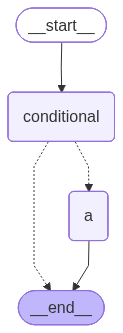

In [ ]:
class State(TypedDict):
    goto: Literal["a", "__end__"]


def node_a(state: State) -> State:
    print("a node is invoked")
    return state


def conditional_node(state: State) -> Command[Literal["a", "__end__"]]:
    return Command(update=state, goto=state["goto"])


graph = (
    StateGraph(State)
    .add_node("conditional", conditional_node)
    .add_node("a", node_a)

    .add_edge(START, "conditional")
    .add_edge("a", END)
    .compile()
)
graph

The following cell invokes the graph with to be executed with the `"a"` node.

In [28]:
_ = graph.invoke(State(goto="a"))

a node is invoked


And alternatively routing directly to the `__end__`.

In [30]:
_ = graph.invoke(State(goto="__end__"))

We always receive messages from random nodes, but always only two of them.

## Memory

You can save the state between the graph infocations. During graph compilation, you must pass a `checkpointer` object. This object will keep the output of the previous invocation bounded to **thread**. The thread is specified by the `configurable.thread_id` field of the `configuration` argument. 

---

The following cell builds and compiles the graph. Note that the checkpointer passes an `InMemorySaver` instance, which stores the information about the outputs of the last invocation in memory. Each time the graph is invoked, a random number is added to the input.

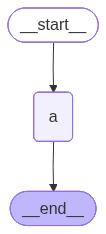

In [103]:
import operator
from random import randint
from typing import Annotated
from langgraph.checkpoint.memory import InMemorySaver

in_memory_saver = InMemorySaver()


class State(TypedDict):
    value: Annotated[list[int], operator.add]


def node_a(state: State) -> State:
    return State(value=[randint(0, 10)])


graph = (
    StateGraph(State)
    .add_node("a", node_a)

    .add_edge(START, "a")
    .add_edge("a", END)

    .compile(checkpointer=in_memory_saver)
)
graph

Invoking such a graph requires specifying the thread because memory is bounded by the thread.

In [104]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9]}

The second invocation with the same specified thread contains the output of the previous invocation, plus the new generated number:

In [105]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 1}}
)

{'value': [9, 2]}

The invocation in the other thread yelds a new number:

In [106]:
graph.invoke(
    State(value=[]),
    {"configurable": {"thread_id": 2}}
)

{'value': [8]}

### Get state

You can obtain a state of the graph compiled with the checkpointer using `get_state` method.

---

The following cell creates a graph with a checkpointer and invokes it.

In [26]:
from langgraph.checkpoint.memory import InMemorySaver


graph = (
    StateGraph(dict)
    .add_edge(START, END)
    .compile(checkpointer=InMemorySaver())
)


config = {"configurable": {"thread_id": 1}}
graph.invoke(dict(val=10), config=config)

{'val': 10}

The following cell shows the output of the `get_config` method.

In [27]:
graph.get_state(config)

StateSnapshot(values={'val': 10}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f9e07-e1f6-6de5-8000-e04695df55ef'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2026-01-25T11:25:03.246459+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0f9e07-e1f2-60b8-bfff-e770c7940135'}}, tasks=(), interrupts=())

## Interrupt

The graph interrupting is a typicall solution involved in popular use cases, such as those associated with the human-in-the-loop approach. There are a few important concepts important to understand in order to implement graph interruption/continuation in LangGraph:

- You can setup the graph interrupting by using:

    - `langgraph.types.interrupt` function from the node of the graph.
    - `interrupt_before` and `interrupt_after` argumens for the graph compilation.
    
- You can get information describing the interruption by:

    - Using the `__interrupt__` attribute returned by the interrupted graph.
    - Some information can be extrated from the snapshot saved by the checkpointer.

- To be able to continue the executing the graph, it must have to be compiled with a checkpointer, which stores the information about all graph's states, and can resume the interrupted ones.

Find out more in the [Interrupt](langgraph/interrupt.ipynb) page.

---

The following cell defines the one-node graph that interrupts during the excution, allowing you to the kind of output produced.

In [10]:
from langgraph.checkpoint import memory
from langgraph.types import interrupt


class State(TypedDict):
    pass


def node_a(state: State) -> State:
    interrupt("Interupted info")
    return state


graph = (
    StateGraph(State)
    .add_node("a", node_a)
    .add_edge(START, "a")
    .add_edge("a", END)
    .compile(checkpointer=memory.InMemorySaver())
)

The following cell shows the outputs of the interrupted graph.

In [28]:
thread = {"configurable": {"thread_id": "1"}}
graph.invoke(State(), thread)

{'__interrupt__': [Interrupt(value='Interupted info', id='0e04d2b8a02da9b262ca333273e6208c')]}

The `get_state` method of the graph returns the state snapshot for the given thread. For example, you can get information about the following node that would be executed using the `next` attribute:

In [36]:
graph.get_state(thread).next

('a',)

## Streaming

The Langgraph's compiled graph allows to stream the process of graph execution using different approaches:

- The `stream` and `astream` methods enable iteration over changing state of the graph.
- The `astream_events` method allows to iterate over langgraph events that are discrete phases in langgraph logic.

Check more in the [streaming](langgraph/streaming.ipynb) page of the documentation.

## Application

LangGraph has an integrated http server that anables communication with the specified graph, allowing you to deploy your graph as an independent application.

The important here is that:

- Your project have to have a specific [structure](https://docs.langchain.com/langsmith/application-structure#python).
- Install optional `pip3 install langgraph-cli[inmem]`.
- Use the langgraph studio to debut your application.


Check a [Run a local server](https://docs.langchain.com/oss/python/langgraph/local-server) as an initial tutorial.

---

The following cell setsup the simplest possible langgraph application.

In [1]:
!rm -rf /tmp/studio && mkdir /tmp/studio

In [1]:
%%writefile /tmp/studio/my_graph.py
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    message: str

def node(state: State) -> State:
    return {"message": state["message"] + " Hello from graph!"}

state_graph = (
    StateGraph(State)
    .add_node("a", node)
    .add_edge(START, "a")
    .add_edge("a", END)
).compile()

Overwriting /tmp/studio/my_graph.py


By settings `LANGSMITH_TRACING=false` environment variable you can turn off the tracking with langsmith.

In [3]:
%%writefile /tmp/studio/.env
LANGSMITH_TRACING=false

Writing /tmp/studio/.env


The `langgraph.json` determines the langgraph application.

In [4]:
%%writefile /tmp/studio/langgraph.json
{
    "dependencies": [
        "langgraph"
    ],
    "graphs": {
        "my_agent": "./my_graph.py:state_graph"
    },
    "env": ".env"
}

Writing /tmp/studio/langgraph.json


Run your langgraph application with commands:

```bash
cd /tmp/studio
langgraph dev
```

You can access the UI of the studio from the LangSmith site typically: `https://smith.langchain.com/studio/?baseUrl=<local address of your application>`.

Your graph is now available via http. You can use the LangGraph SDK to interact with the application.

The following cells demonstrate how you can invoke the graph deployed as the application.

In [17]:
from langgraph_sdk import get_sync_client

client = get_sync_client(url="http://localhost:2024")
assistants = client.assistants.search()
thread = client.threads.create()

assistant_id = assistants[0]["assistant_id"]
thread_id = thread["thread_id"]

for event in client.runs.stream(
    thread_id,
    assistant_id,
    input={"message": "Hello from SDK!"},
    stream_mode="values",
):
    print(event)

StreamPart(event='metadata', data={'run_id': '019bad7f-636f-7b13-85d5-7754df873e17', 'attempt': 1}, id=None)
StreamPart(event='values', data={'message': 'Hello from SDK!'}, id=None)
StreamPart(event='values', data={'message': 'Hello from SDK! Hello from graph!'}, id=None)
